In [51]:
from dataAnalyzer import *
from private_tool import *
from dataHandler import *
from numpy import array

In [52]:
experimentNum = 9
experimentIdx = 4
Experiments = [MotorImageryDataset(parentDirectory(dir=currDir, separator="\\", n=1)+'/bcicompetitionIV2a/A0'+str(i+1)+'T.npz') for i in range(experimentNum)]

In [53]:
channels = [7, 9, 10, 11]
samplingRate = 250 #Hz
trialsByClasses = array([i.get_trials_by_classes(channels=channels) for i in Experiments])

In [54]:
len(trialsByClasses[0]["left"][0])

69

In [55]:
channelNum = len(channels)
m = len(trialsByClasses[0]["left"])
channelNum, m

(4, 4)

In [56]:
bandpassedTrialsByClasses = [{i:[[] for _ in range(channelNum)] for i in j.mi_types.values()} for j in Experiments]
for k in range(experimentNum):
    for key in trialsByClasses[k].keys():
        for i in range(channelNum):
            bandpassedTrialsByClasses[k][key][i] = np.array([bandpass_filter(data=trialsByClasses[k][key][i][j], 
                                                                sample_rate=samplingRate, 
                                                                cutoff_low=5, 
                                                                cutoff_high=50)\
                                                for j in range(len(trialsByClasses[k][key][i]))])

In [57]:
# bandpassedTrialsByClasses[2]["left"][2].shape

In [58]:
# 현재 상태는 experiment - class - channel - trial - signal
# class - experiment - trial - channel - signal로 수정하자
bandpassedTrialsByClasses = {key:array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}
# bandpassedTrialsByClasses["left"][8][0].shape
# i: experiment
# j: trial

C:\Users\jihun\AppData\Local\Temp\ipykernel_19528\3323506164.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bandpassedTrialsByClasses = {key:array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}


In [60]:
minTrialsNum = sorted([len(bandpassedTrialsByClasses["left"][i][0]) for i in range(experimentNum)])[0]
bandpassedTrialsByClasses = {i:[bandpassedTrialsByClasses[i][j] for j in range(experimentNum)] for i in Experiments[0].mi_types.values()}

In [61]:
left_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["left"][experimentIdx]), bandpassedTrialsByClasses["left"][experimentIdx])
right_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["right"][experimentIdx]), bandpassedTrialsByClasses["right"][experimentIdx])

In [62]:
bandpassedTrials = {i:[] for i in Experiments[0].mi_types.values()}
for i in Experiments[0].mi_types.values():
    for j in range(len(bandpassedTrialsByClasses)):
        bandpassedTrials[i]

In [63]:
# CSP_passed_left_data = np.array([[bandpassedTrialsByClasses[i][j].T@left_csp_filter for j in range(minTrialsNum)] for i in range(experimentNum)])
CSP_passed_left_data = [j.T@left_csp_filter for j in bandpassedTrialsByClasses["left"][experimentIdx]]
CSP_passed_right_data = [j.T@right_csp_filter for j in bandpassedTrialsByClasses["right"][experimentIdx]]

In [64]:
len(CSP_passed_left_data)

4

In [65]:
# bandpassedTrialsByClasses["right"][0]["right"][0]

In [66]:
print(array(CSP_passed_left_data).shape)
CSP_passed_left_data = [np.array([j.T for j in i]).T for i in CSP_passed_left_data]
CSP_passed_right_data = [np.array([j.T for j in i]).T for i in CSP_passed_right_data]

(4, 1875, 63)


In [67]:
array(CSP_passed_left_data).shape

(4, 63, 1875)

In [68]:
CSP_passed_left_data = array([i.T for i in array(CSP_passed_left_data).T]).T
CSP_passed_right_data = array([i.T for i in array(CSP_passed_right_data).T]).T

In [69]:
from math import log
m = 2
print(len(CSP_passed_left_data))

leftVar = np.array([np.array([np.var(CSP_passed_left_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])
rightVar = np.array([np.array([np.var(CSP_passed_right_data[i][j]) for j in range(channelNum)]) for i in range(minTrialsNum)])

leftVarRatio = np.array([np.array([log(leftVar[i][j-m]/sum(leftVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])
rightVarRatio = np.array([np.array([log(rightVar[i][j-m]/sum(rightVar[i])) for j in range(m*2)]) for i in range(minTrialsNum)])

63


In [70]:
leftVarRatioDF = pd.DataFrame(leftVarRatio)
rightVarRatioDF = pd.DataFrame(rightVarRatio)
labelDF = pd.DataFrame([0]*minTrialsNum + [1]*minTrialsNum)

In [71]:
VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF], axis=0)
VarRatioDF = VarRatioDF.reset_index()
VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:,1:]
VarRatioDF.columns = [f"{n}" for n in range(m*2)] + ["target"]
VarRatioDF

,0,1,2,3,target
0,-1.341686,-1.375909,-1.508145,-1.329289,0
1,-1.319647,-1.360280,-1.540549,-1.339723,0
2,-1.322623,-1.360038,-1.560490,-1.320955,0
3,-1.383672,-1.407935,-1.430328,-1.326271,0
4,-1.335653,-1.396957,-1.542515,-1.287998,0
...,...,...,...,...,...
101,-1.350408,-1.354294,-1.505757,-1.343669,1
102,-1.369684,-1.372262,-1.441057,-1.364132,1
103,-1.352472,-1.356590,-1.522268,-1.325591,1
104,-1.341708,-1.324032,-1.564747,-1.334083,1


In [72]:
from sklearn.preprocessing import StandardScaler, RobustScaler
x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3
0,0.291019,0.493336,-0.262119,-0.455810
1,1.444755,0.942529,-0.975617,-0.940842
2,1.288957,0.949503,-1.414681,-0.068371
3,-1.907044,-0.427152,1.451305,-0.315514
4,0.606814,-0.111629,-1.018890,1.463741
...,...,...,...,...
101,-0.165611,1.114603,-0.209538,-1.124309
102,-1.174721,0.598155,1.215076,-2.075588
103,-0.273681,1.048589,-0.573075,-0.283883
104,0.289873,1.984384,-1.508410,-0.678661


In [73]:
PCA = PrincipalComponentAnalysis(n_componunts=2, data=x)
principalDf = PCA.principalDf

In [74]:
sum(PCA.explained_variance_ratio_())

0.9086168868005955

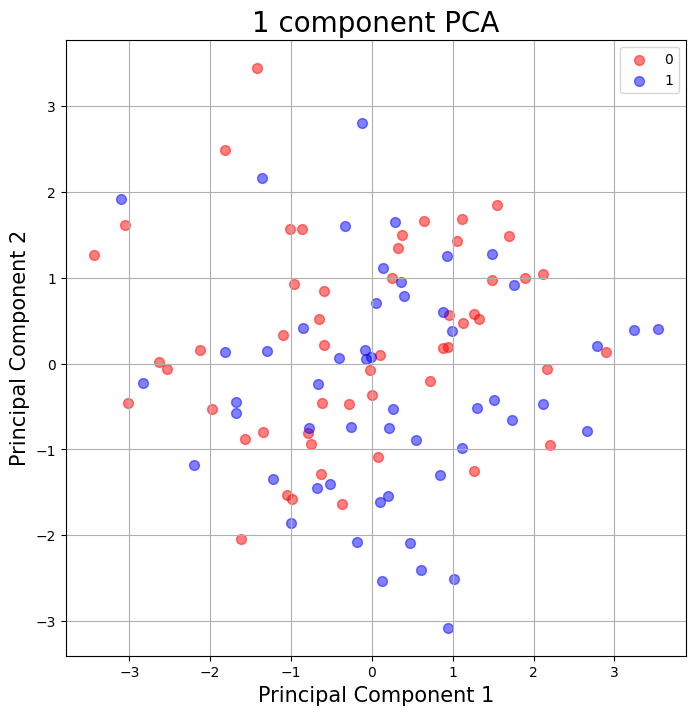

In [75]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('1 component PCA', fontsize=20)

targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = VarRatioDF['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
               , principalDf.loc[indicesToKeep, 'principal component2']
               , c = color
               , s = 50, alpha=0.5)
ax.legend(targets)
ax.grid()

In [76]:
pd.concat([principalDf.loc[:, 'principal component1'], principalDf.loc[:, 'principal component2'], labelDF], axis=1)

,principal component1,principal component2,0
0,-0.611847,-0.453517,0
1,-1.977982,-0.524338,0
2,-2.129795,0.157184,0
3,2.207169,-0.943319,0
4,-0.858319,1.562077,0
...,...,...,...
101,-0.681161,-1.453144,1
102,1.016933,-2.513116,1
103,-0.774632,-0.754551,1
104,-2.201222,-1.177600,1
